# PREDICTIVE MODELING

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax

from glob import glob
from os.path import join

import cloudpickle
import lbc.data as d

## LOAD DATA

In [4]:
# load images
X_tr, X_va, _ = d.split(d.load())

Loading images: 100%|██████████| 1774/1774 [00:32<00:00, 55.06it/s]


In [45]:
def load_metadata():
    # figure out which files were in the which set
    all_files = sorted(glob(f'{d.DATA_DIR}/arcs/*.npy'))
    rng = np.random.default_rng(0)
    N = len(all_files)
    indices = np.arange(N)
    rng.shuffle(indices)
    idx_train, idx_val, idx_test = d.split(indices)
    
    def _transform(fname):
        # make filenames look like the ones in the df
        chunks = fname.split('-')
        frame = chunks[-1].split('.')[0]
        camera = chunks[-2]
        return f"sdR-{camera}-{frame}.fit"
    
    all_metadata = pd.read_csv(f'{d.DATA_DIR}/arcs/metadata.csv')

    dfs = []
    
    for idx in (idx_train, idx_val, idx_test):
        files = np.array(all_files)[idx]
        df_filenames = np.array([ _transform(f) for f in files ])
        
        m_filenames = all_metadata.FILENAME.values
        search = m_filenames.reshape((1, -1)) == df_filenames.reshape((-1, 1))
        indices = np.nonzero(search)[1]
        df = all_metadata.iloc[indices].copy()
        df.drop_duplicates('FILENAME', inplace=True)
        
        dfs.append(df)
        
    return dfs

meta_tr, meta_va, _ = load_metadata()

In [6]:
# load model
with open('/scratch/ch4407/lbc/checkpoints/h4_l002/checkpoint_50000.pkl', 'rb') as f:
    model, _, _, _ = cloudpickle.load(f)

## PREPARE DATA

In [53]:
# compute embeddings
embed_tr = jax.vmap(model.encoder)(X_tr)
embed_va = jax.vmap(model.encoder)(X_va)

In [8]:
# define maybe interesting columns
interesting_columns = [
    'CAMERAS',
    'AZ', 'ALT', 'IPA', 'FOCUS',
    'M2PISTON', 'M2XTILT', 'M2YTILT', 'M2XTRAN', 'M2YTRAN', #'M2ZROT',
    'M1PISTON', 'M1XTILT', 'M1YTILT', 'M1XTRAN', 'M1YTRAN', #'M1ZROT',
    'SCALE',
    'PRESSURE',
    'WINDD', 'WINDS',
    'GUSTD', 'GUSTS',
    'AIRTEMP', 'DEWPOINT', 'HUMIDITY',
    'DUSTA', 'DUSTB',
]

len(interesting_columns)

26

In [46]:
def prep_metadata(df):
    out = df[interesting_columns].copy()
    out['CAMERAS'] = (out['CAMERAS'] == 'r1').astype(np.float64)
    
    # clamp them all to (0, 1) who cares
    out = (out - out.min()) / (out.max() - out.min())
    return out

df_tr = prep_metadata(meta_tr)
df_va = prep_metadata(meta_va)
print('All floats?')
print('  tr:', (df_tr.dtypes == 'float64').all())
print('  va:', (df_va.dtypes == 'float64').all())

All floats?
  tr: True
  va: True


In [49]:
# Rectangularize
M_tr = df_tr.values
M_va = df_va.values

M_tr.shape, M_va.shape

((1420, 26), (177, 26))

In [54]:
embed_tr.shape, embed_va.shape

((1420, 2), (177, 2))

## Given metadata, predict embedding

We had talked about doing something more sophisticated, e.g. having the predictive model take a _reference_ image (e.g. from the same night) and metadata as well as the current metadata, and predict the current image from that. This would allow us to use other less-well-captured information about the night on top of the metadata.

But, as a start, let's skip the reference and _just_ predict embeddings from metadata alone.

### Dumbest model possible: least squares

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [61]:
lsq = LinearRegression().fit(M_tr, embed_tr)

print("Train perf:")
pred = lsq.predict(M_tr)
print(f"  mse: {mean_squared_error(embed_tr, pred):.2f}")
# The coefficient of determination: 1 is perfect prediction
print(f"  r^2: {r2_score(embed_tr, pred):.2f}")

print("Validation perf:")
pred = lsq.predict(M_va)
print(f"  mse: {mean_squared_error(embed_va, pred):.2f}")
# The coefficient of determination: 1 is perfect prediction
print(f"  r^2: {r2_score(embed_va, pred):.2f}")

Train perf:
  mse: 198.81
  r^2: 0.82
Validation perf:
  mse: 207.41
  r^2: 0.81


In [78]:
def mse_loss(x_hat, x):
    mse = ((x_hat - x)**2).mean()
    return mse

reco mse (tr): 0.03665764257311821
pred mse (tr): 0.06101849302649498


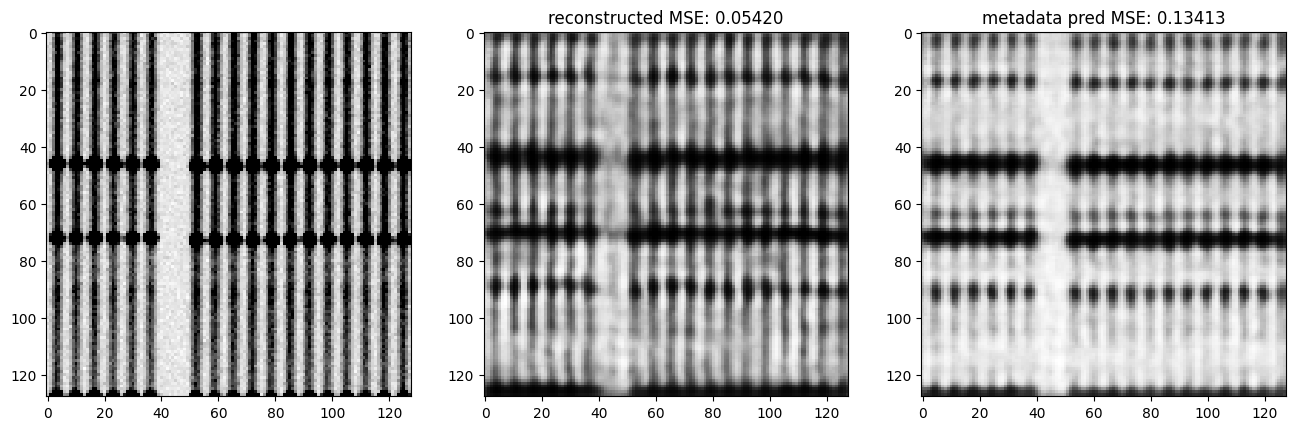

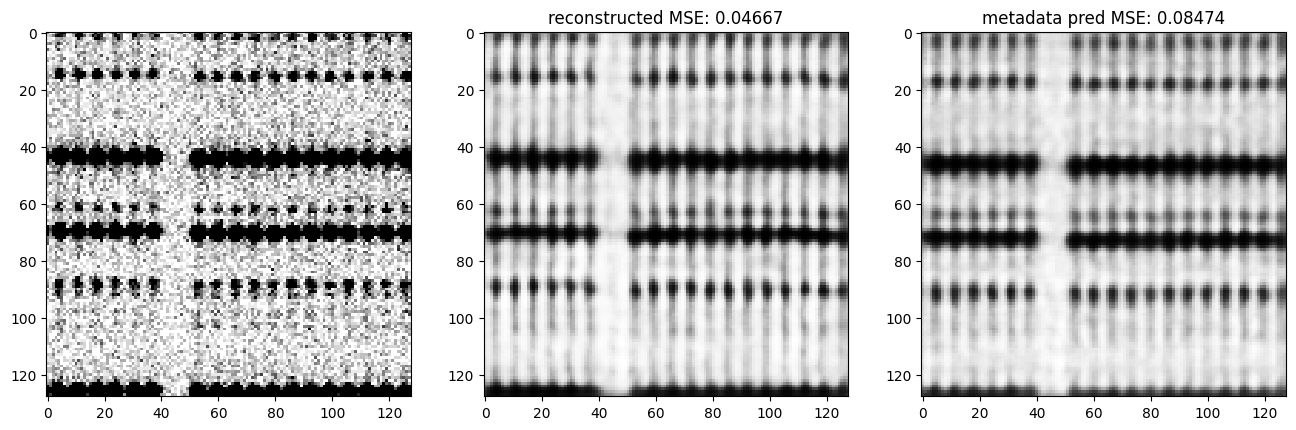

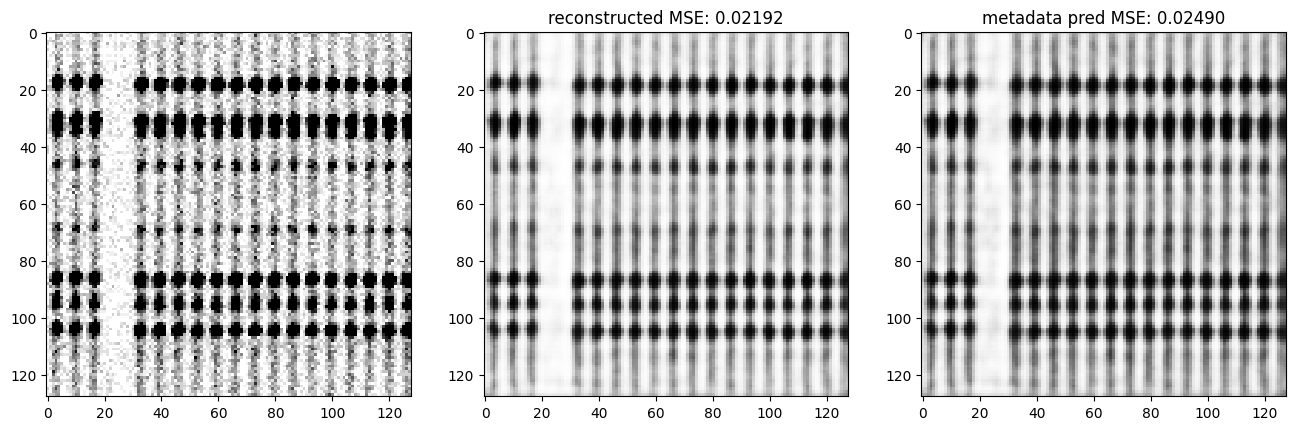

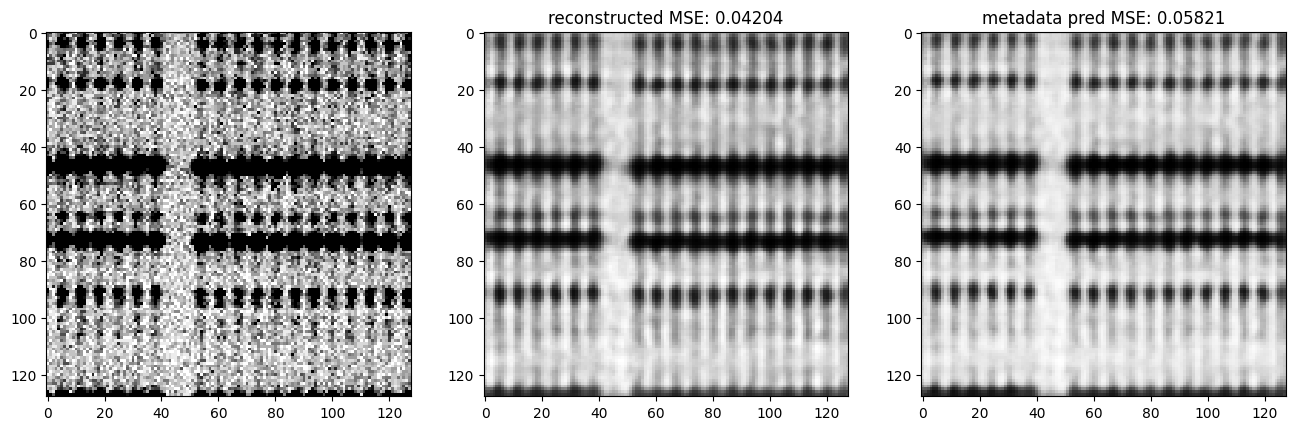

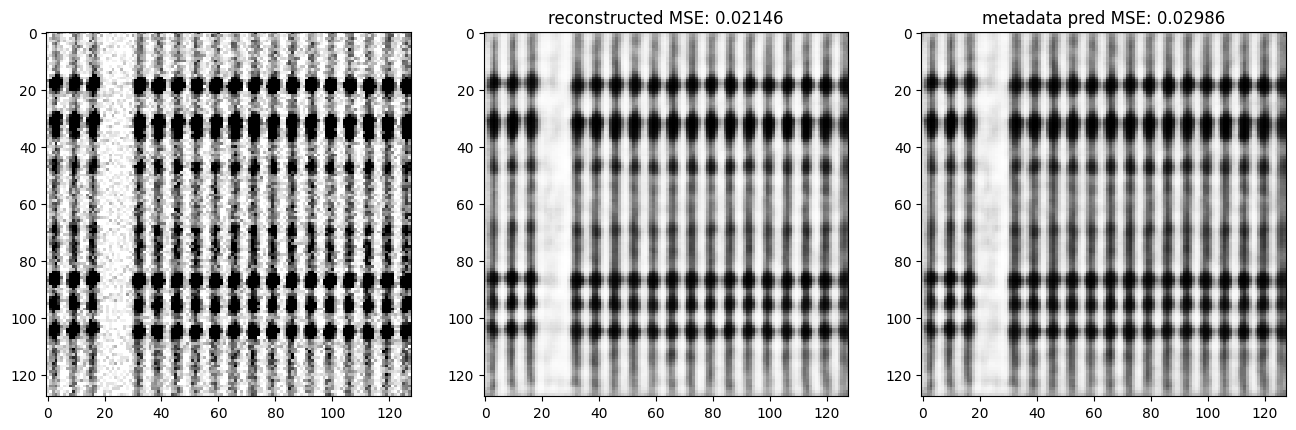

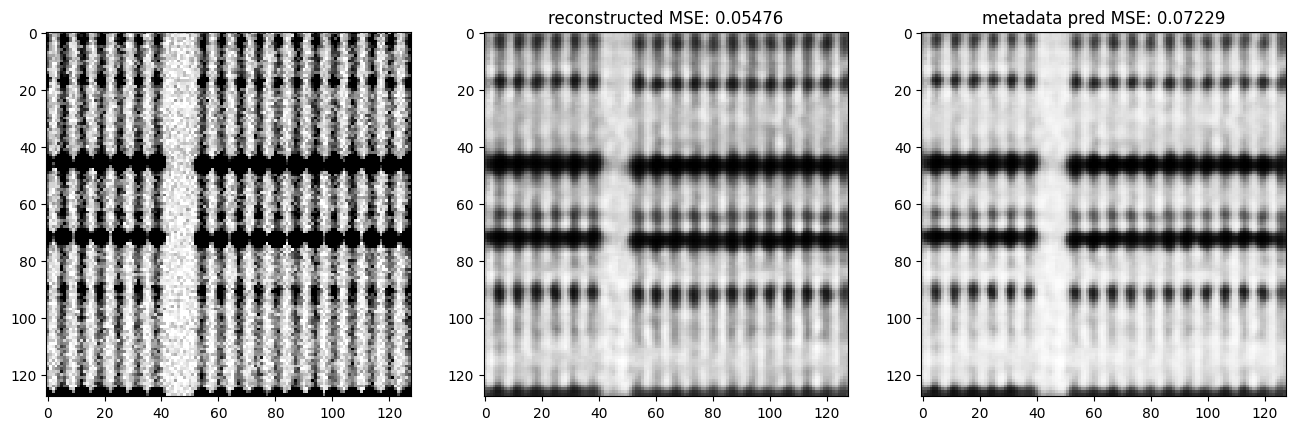

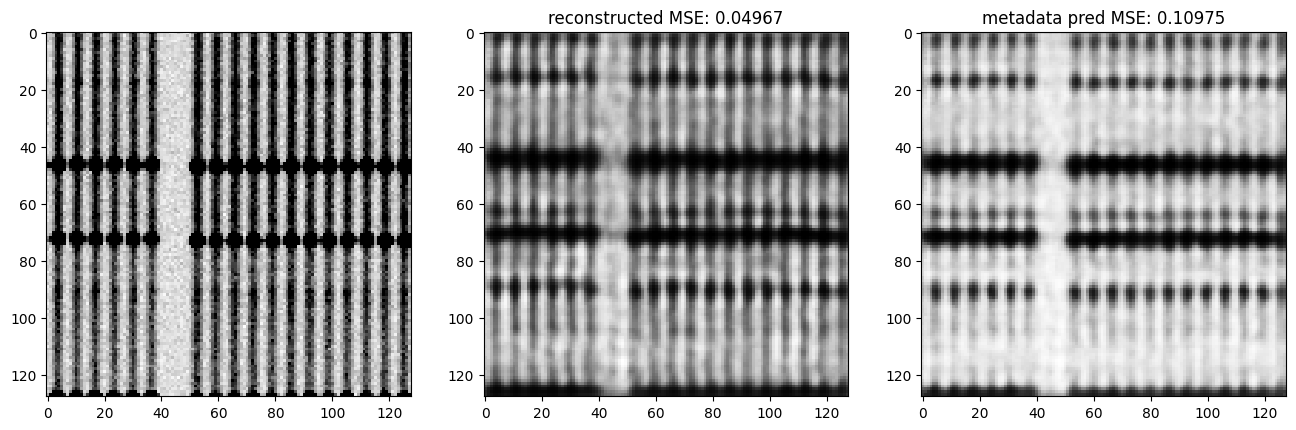

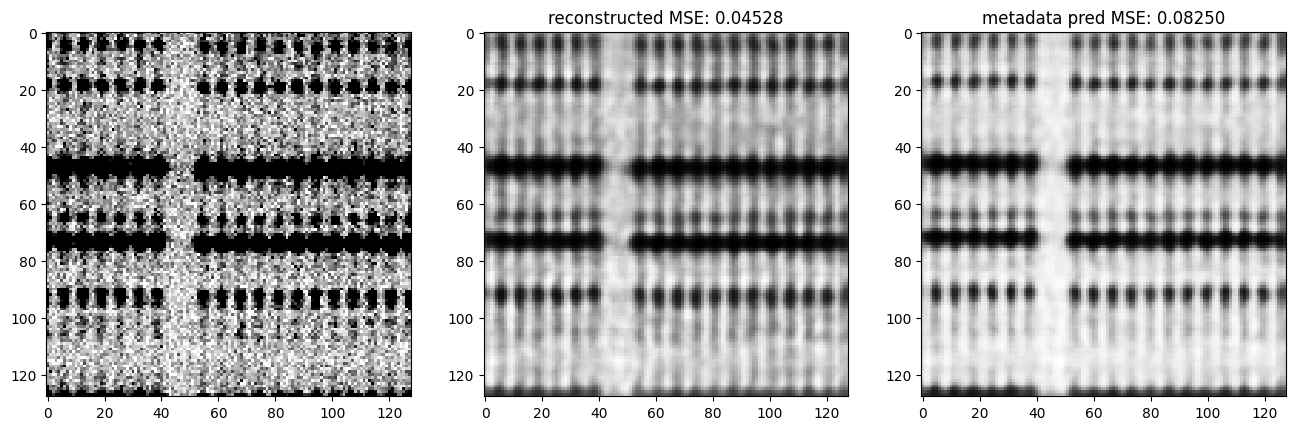

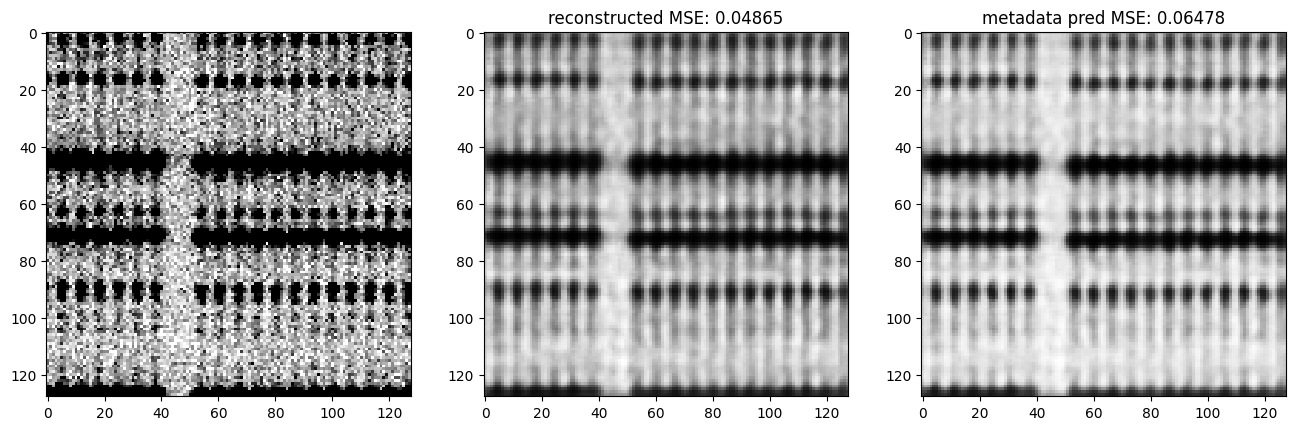

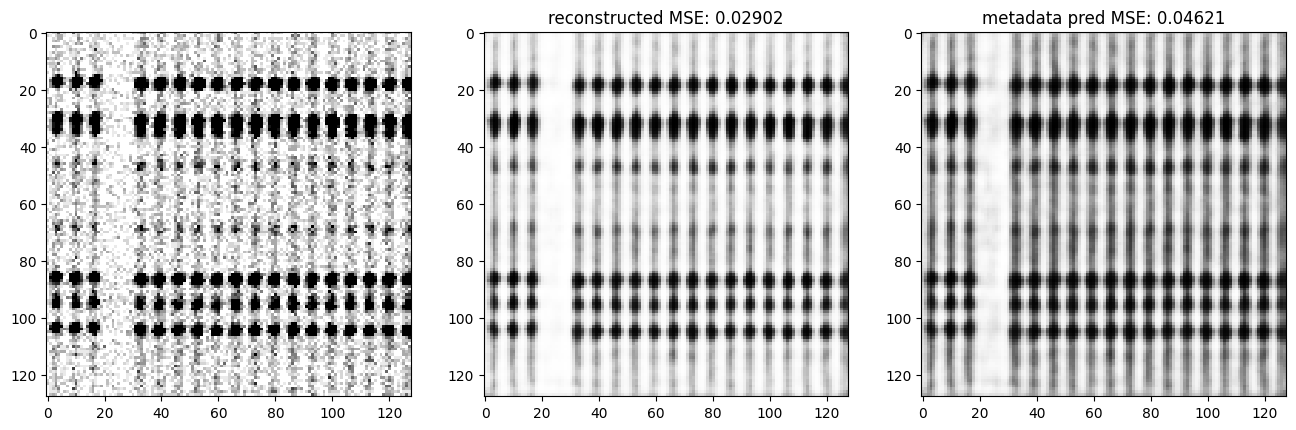

In [86]:
# and let's go all the way back to images and see how it looks
pred = lsq.predict(M_tr)
reco_img = jax.vmap(model)(X_tr)
pred_img = jax.vmap(model.decoder)(pred)

print(f'reco mse (tr): {mse_loss(reco_img, X_tr)}')
print(f'pred mse (tr): {mse_loss(pred_img, X_tr)}')

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].imshow(X_tr[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].imshow(reco_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].set_title(f"reconstructed MSE: {mse_loss(reco_img[i], X_tr[i]):.5f}")
    axs[2].imshow(pred_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[2].set_title(f"metadata pred MSE: {mse_loss(pred_img[i], X_tr[i]):.5f}")
    plt.show()

reco mse (va): 0.03526788949966431
pred mse (va): 0.06365229189395905


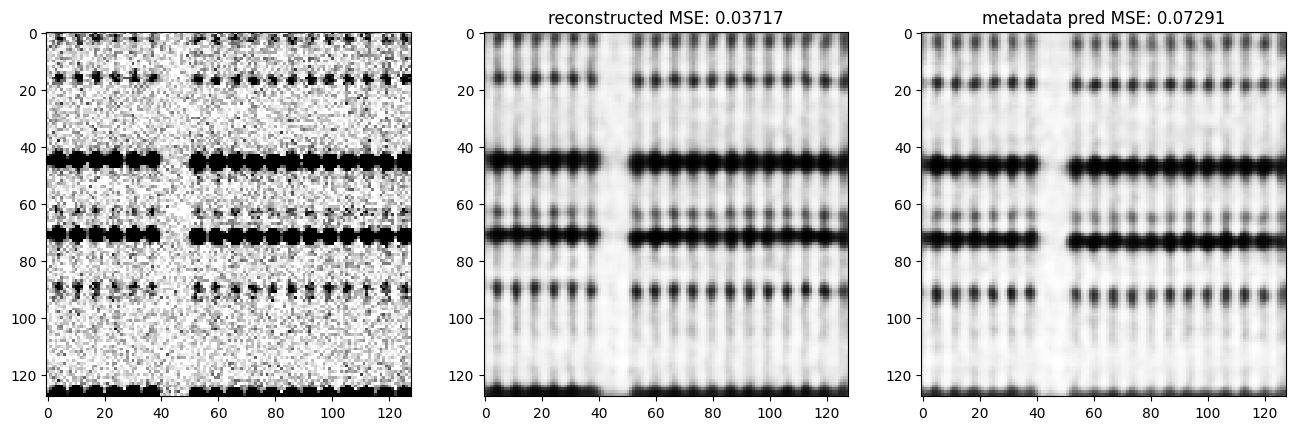

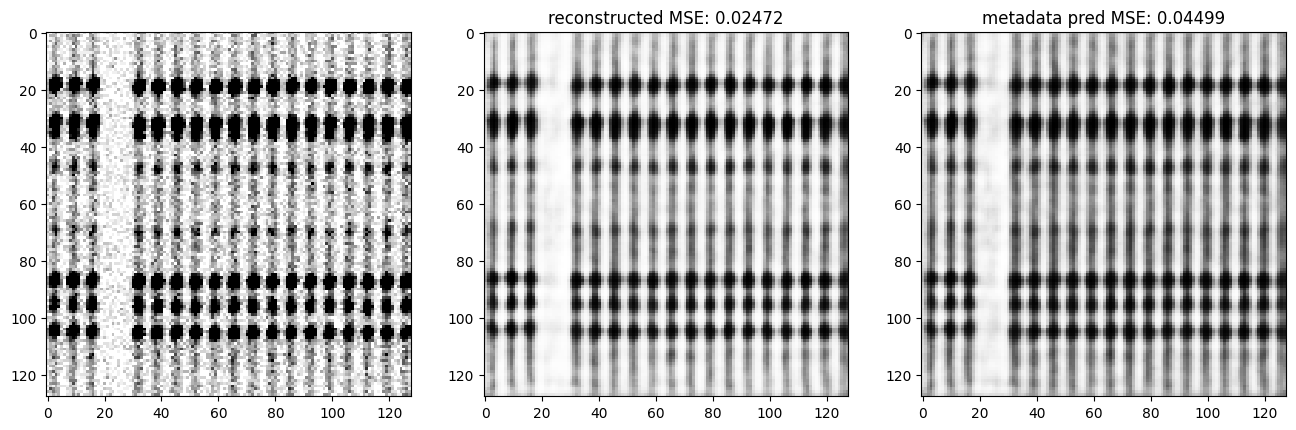

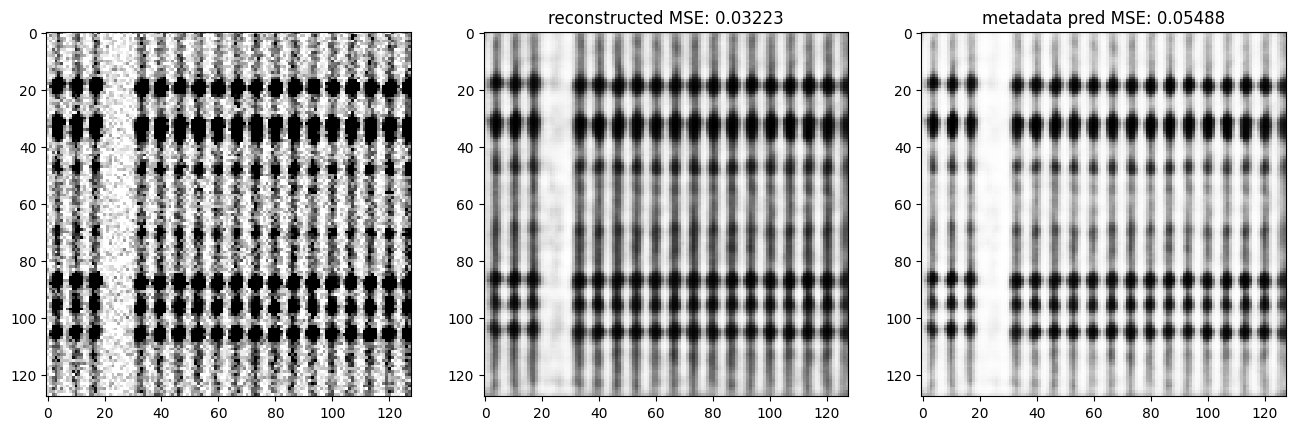

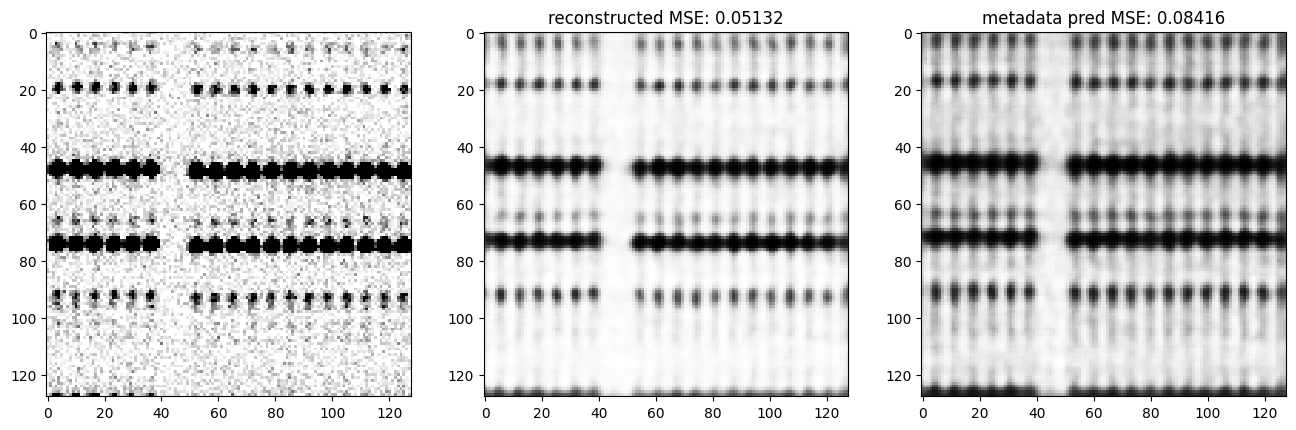

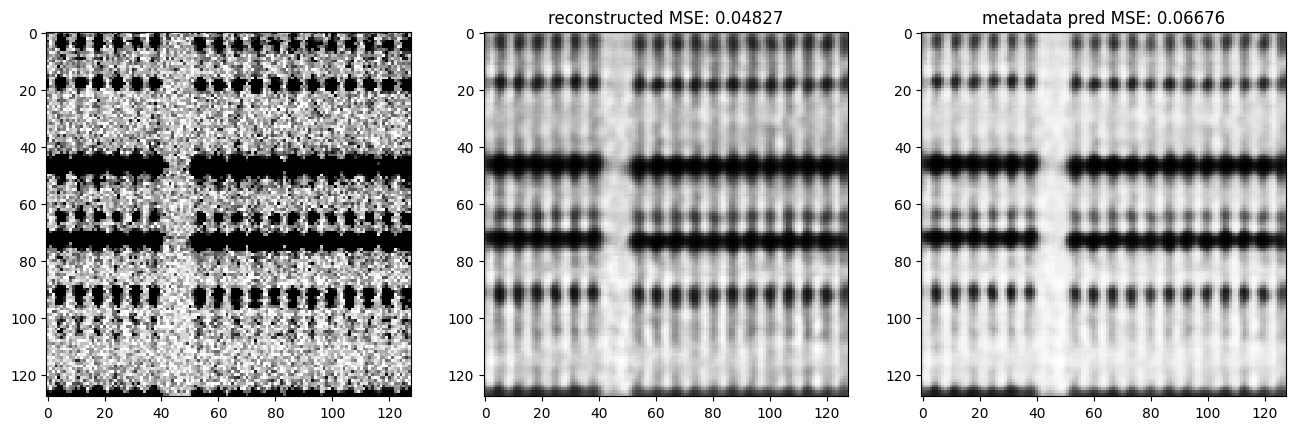

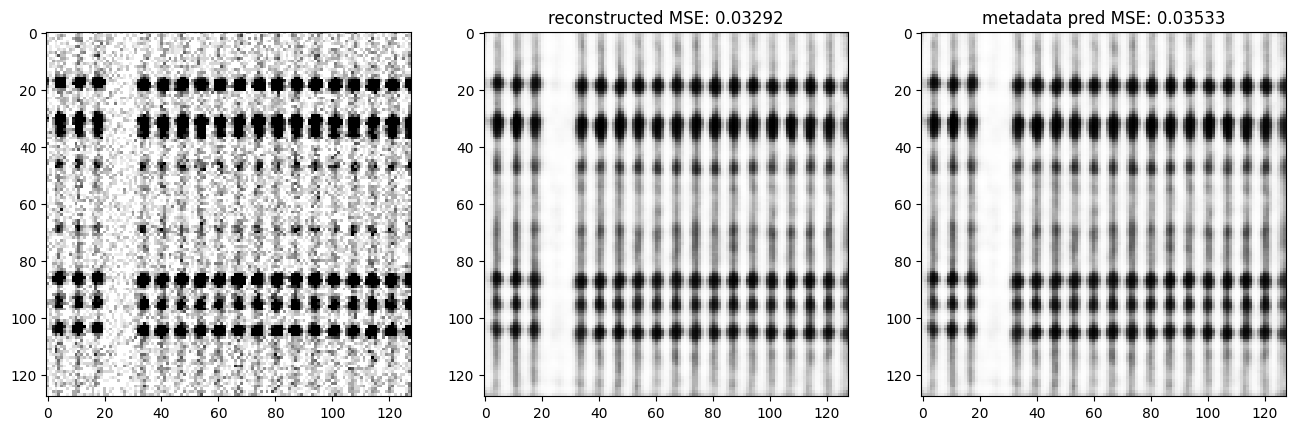

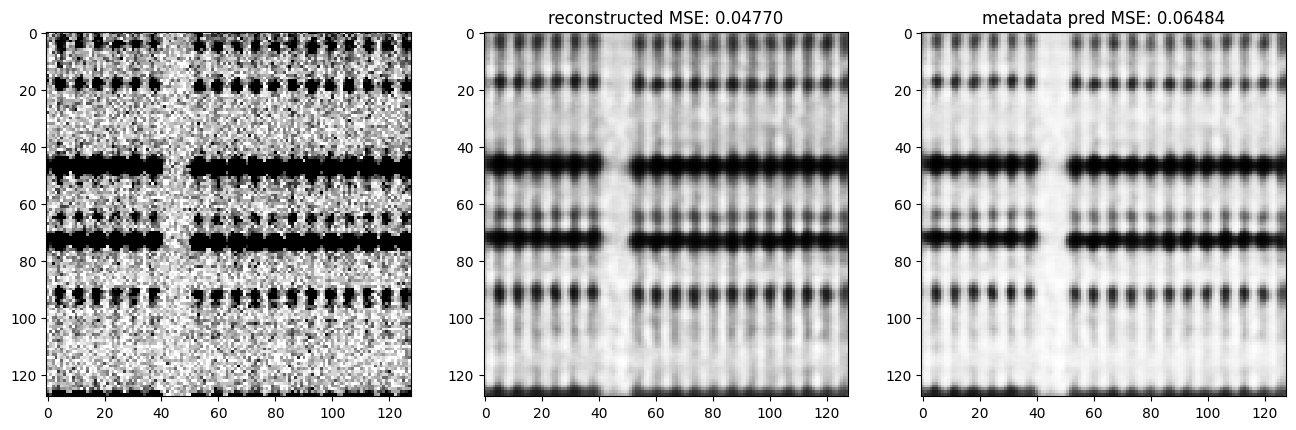

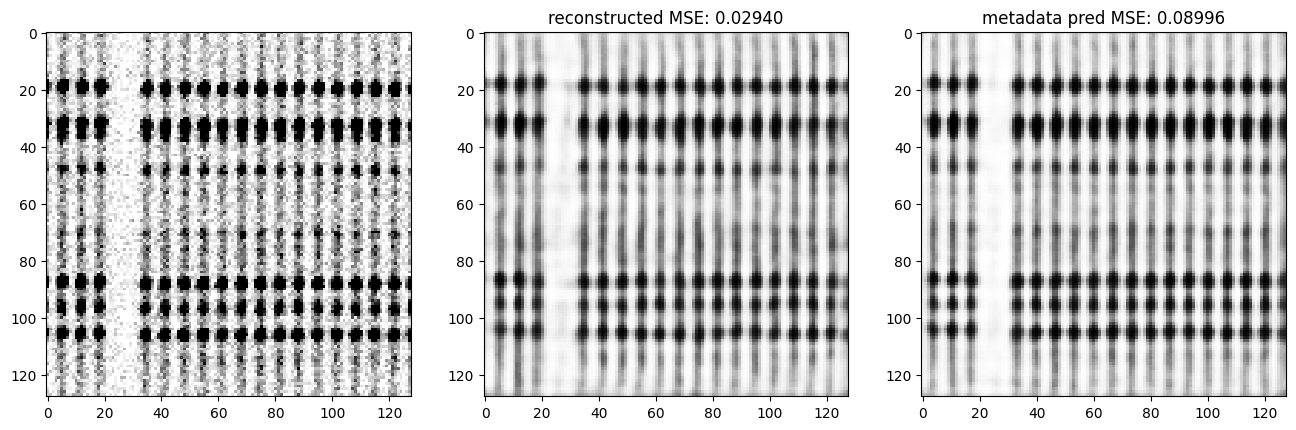

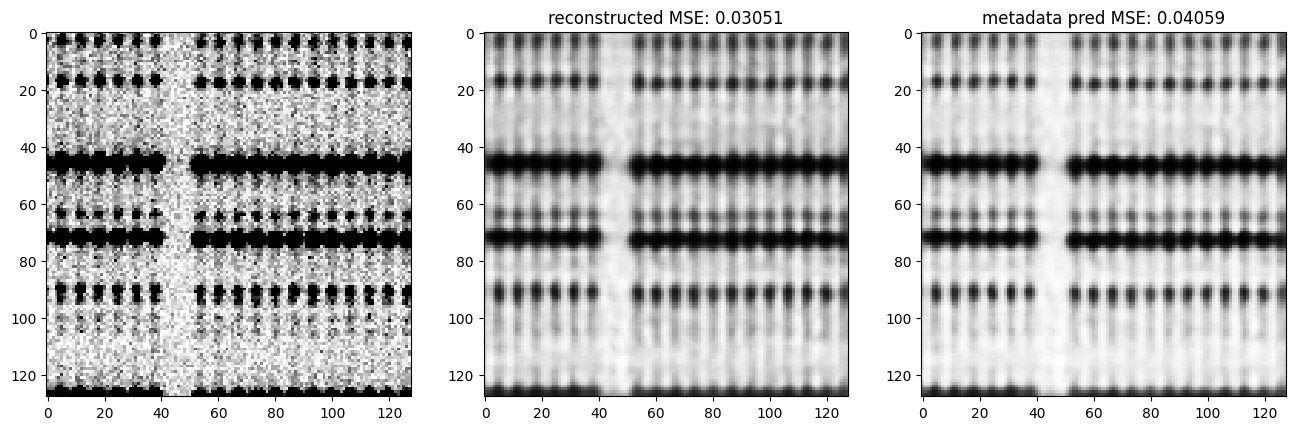

In [ ]:
pred = lsq.predict(M_va)
reco_img = jax.vmap(model)(X_va)
pred_img = jax.vmap(model.decoder)(pred)

print(f'reco mse (va): {mse_loss(reco_img, X_va)}')
print(f'pred mse (va): {mse_loss(pred_img, X_va)}')

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].imshow(X_va[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].imshow(reco_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].set_title(f"reconstructed MSE: {mse_loss(reco_img[i], X_va[i]):.5f}")
    axs[2].imshow(pred_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[2].set_title(f"metadata pred MSE: {mse_loss(pred_img[i], X_va[i]):.5f}")
    plt.show()

### Can we do better with a more bloated model?

In [88]:
from sklearn.neural_network import MLPRegressor

In [91]:
mlp = MLPRegressor(max_iter=5_000).fit(M_tr, embed_tr)

print("Train perf:")
pred = mlp.predict(M_tr)
print(f"  mse: {mean_squared_error(embed_tr, pred):.2f}")
# The coefficient of determination: 1 is perfect prediction
print(f"  r^2: {r2_score(embed_tr, pred):.2f}")

print("Validation perf:")
pred = mlp.predict(M_va)
print(f"  mse: {mean_squared_error(embed_va, pred):.2f}")
# The coefficient of determination: 1 is perfect prediction
print(f"  r^2: {r2_score(embed_va, pred):.2f}")

Train perf:
  mse: 178.19
  r^2: 0.83
Validation perf:
  mse: 170.40
  r^2: 0.85


reco mse (tr): 0.03665764257311821
pred mse (tr): 0.05812849476933479


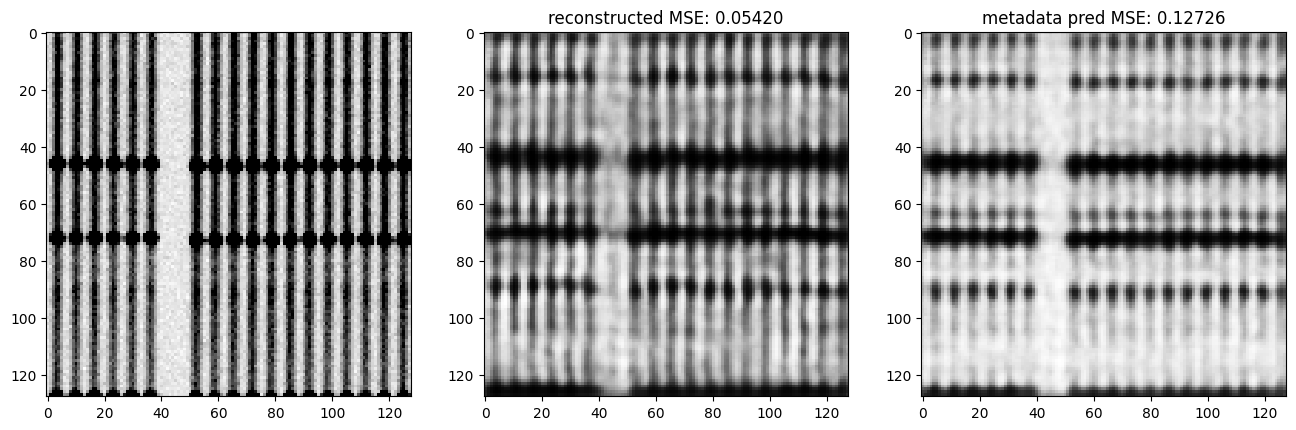

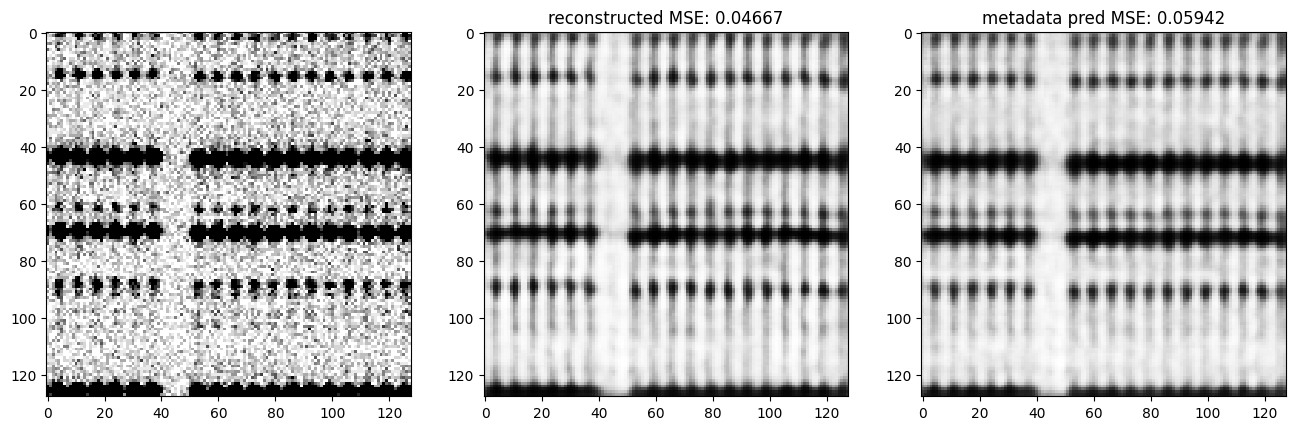

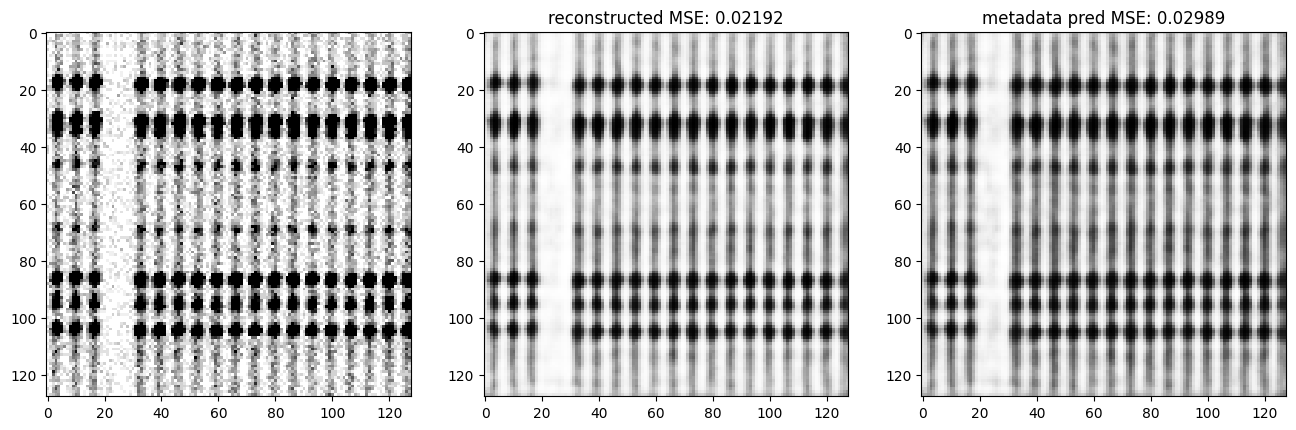

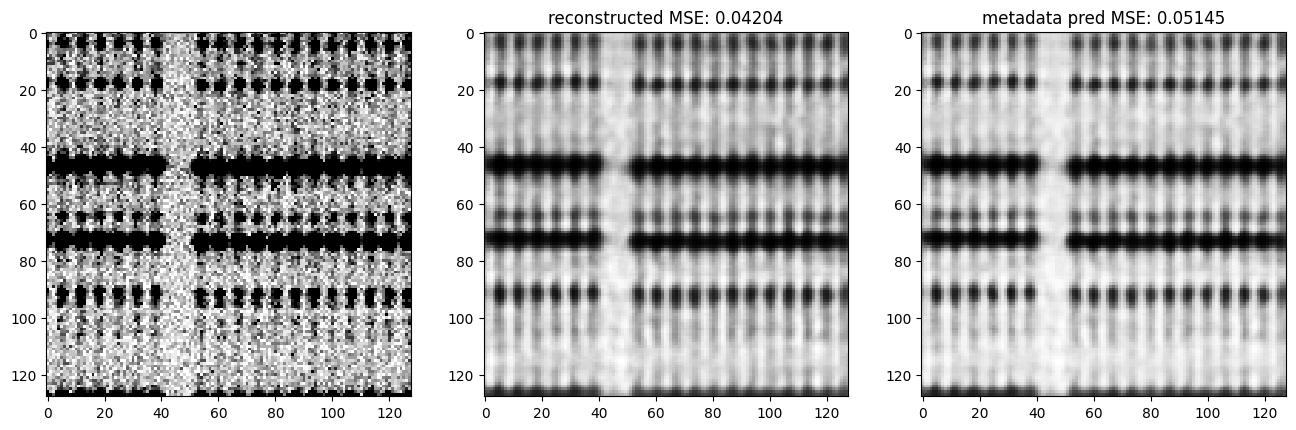

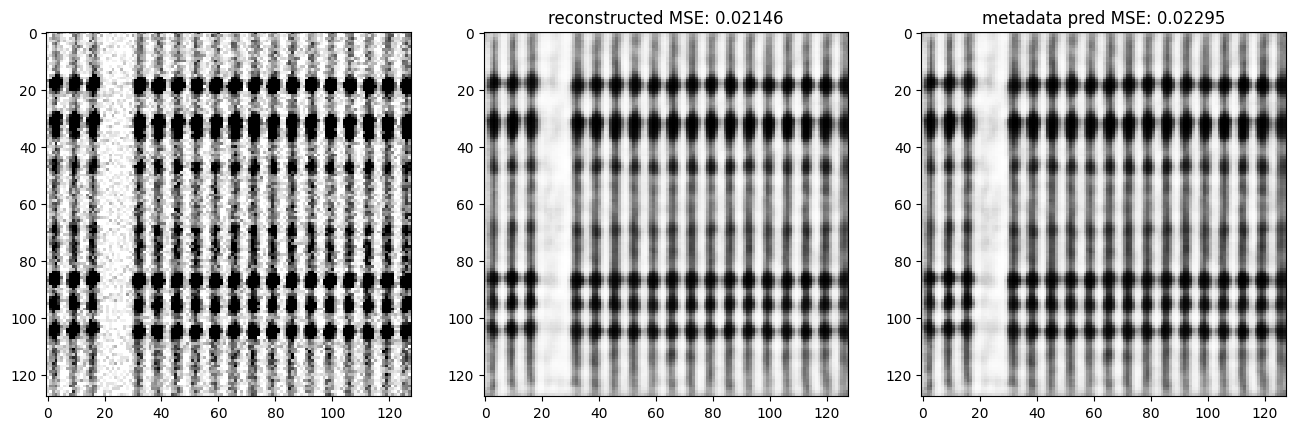

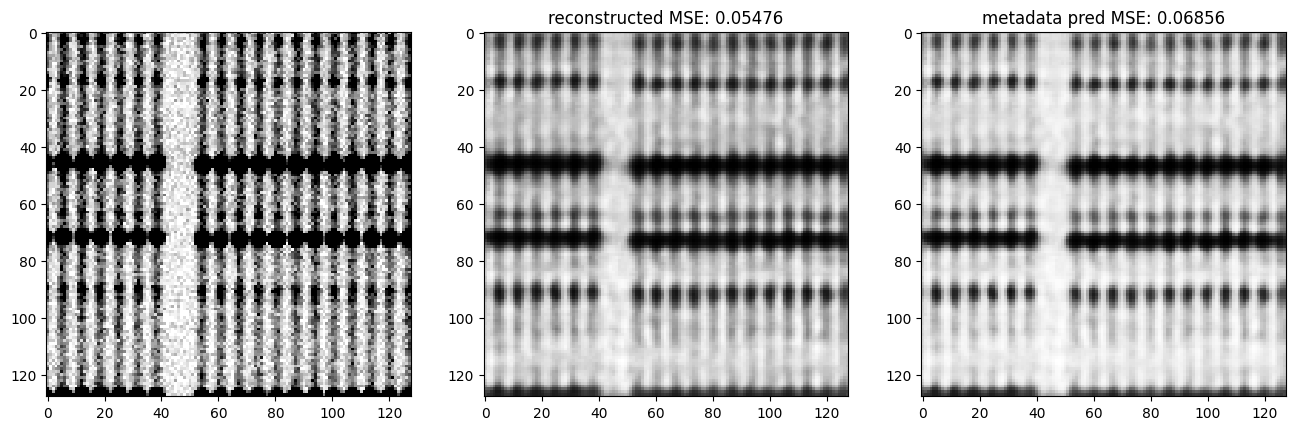

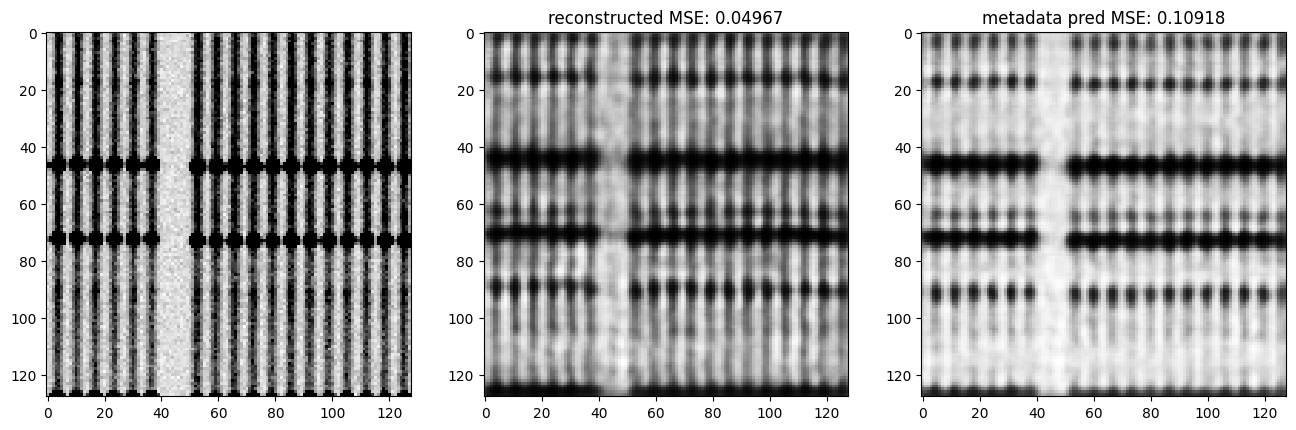

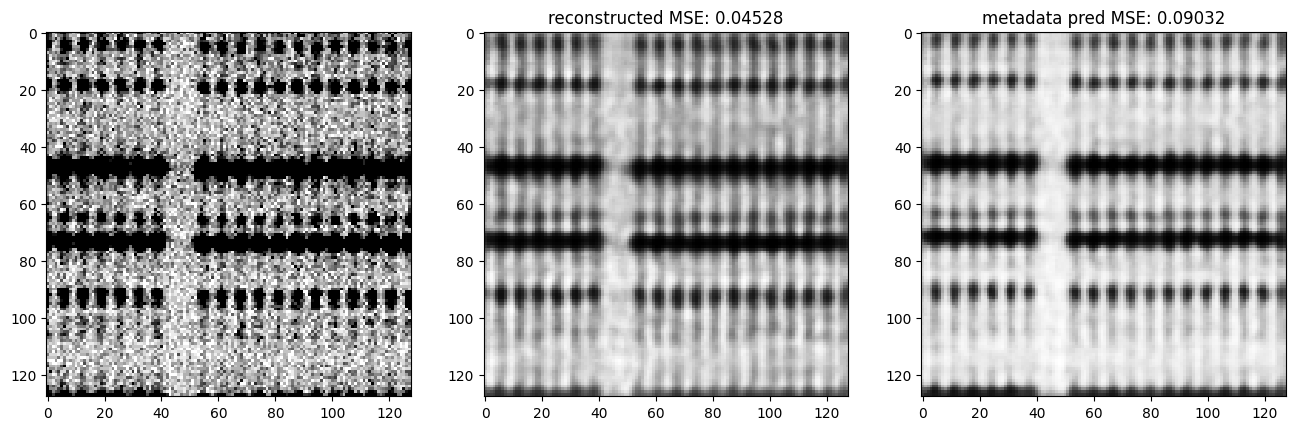

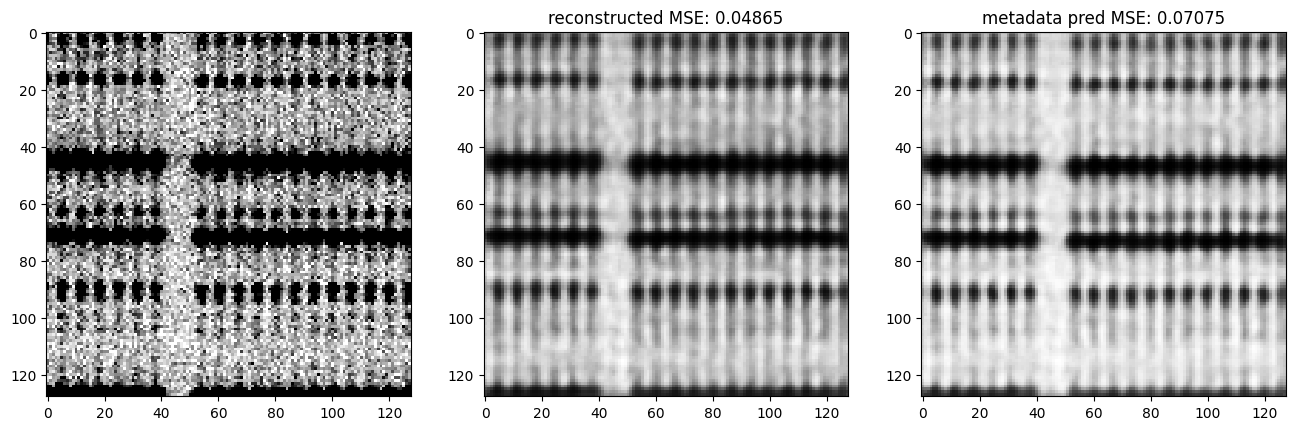

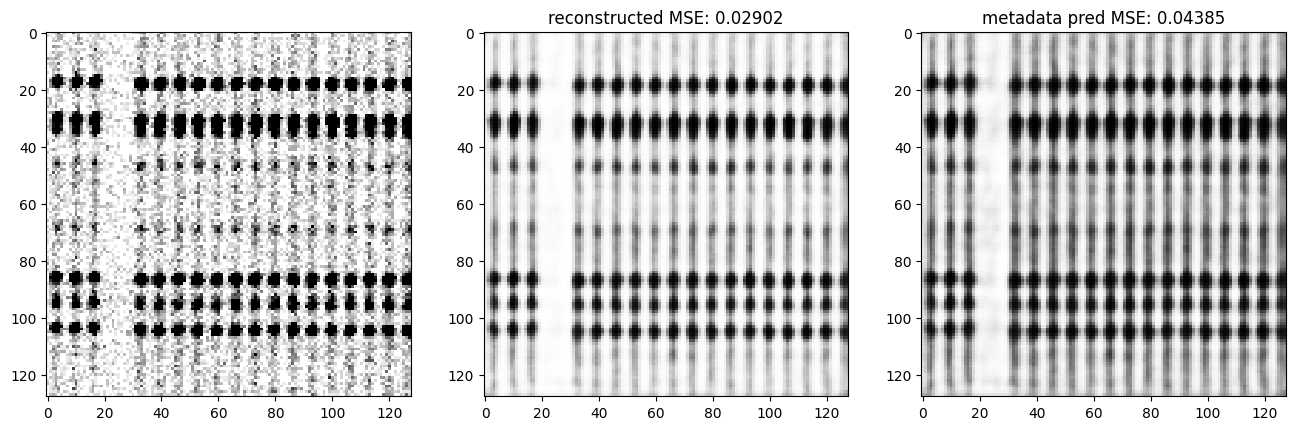

In [92]:
# and let's go all the way back to images and see how it looks
pred = mlp.predict(M_tr)
reco_img = jax.vmap(model)(X_tr)
pred_img = jax.vmap(model.decoder)(pred)

print(f'reco mse (tr): {mse_loss(reco_img, X_tr)}')
print(f'pred mse (tr): {mse_loss(pred_img, X_tr)}')

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].imshow(X_tr[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].imshow(reco_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].set_title(f"reconstructed MSE: {mse_loss(reco_img[i], X_tr[i]):.5f}")
    axs[2].imshow(pred_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[2].set_title(f"metadata pred MSE: {mse_loss(pred_img[i], X_tr[i]):.5f}")
    plt.show()

reco mse (va): 0.03526788949966431
pred mse (va): 0.0582103356719017


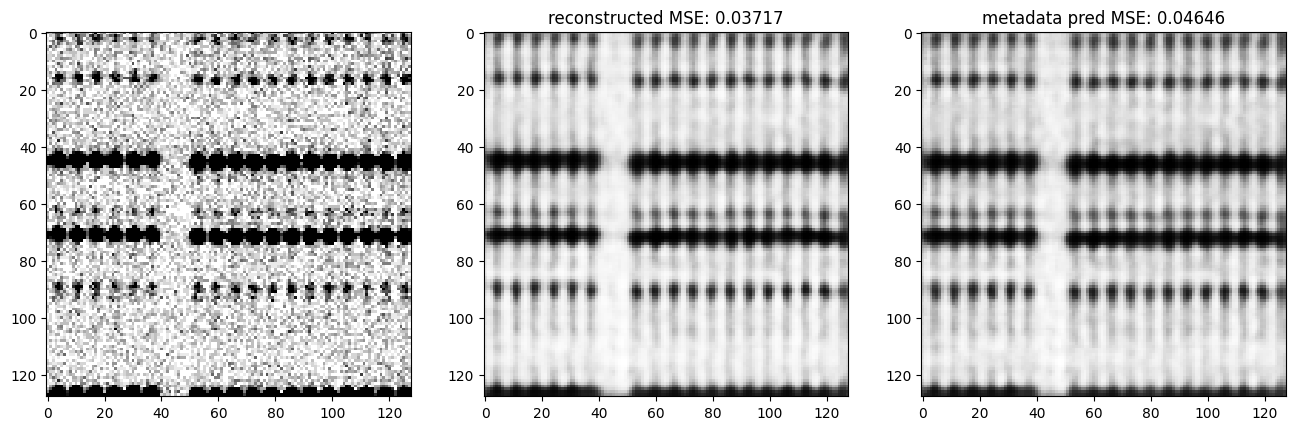

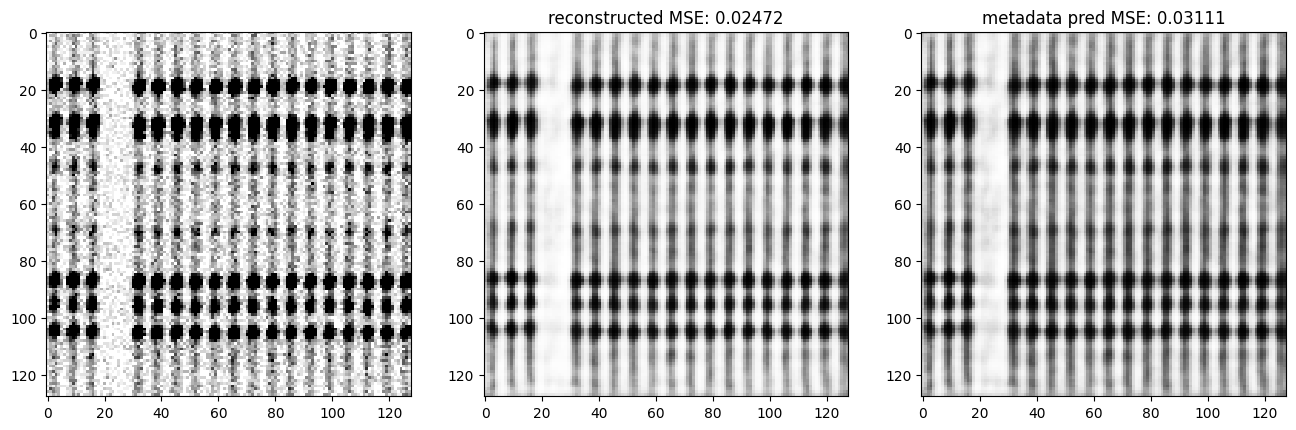

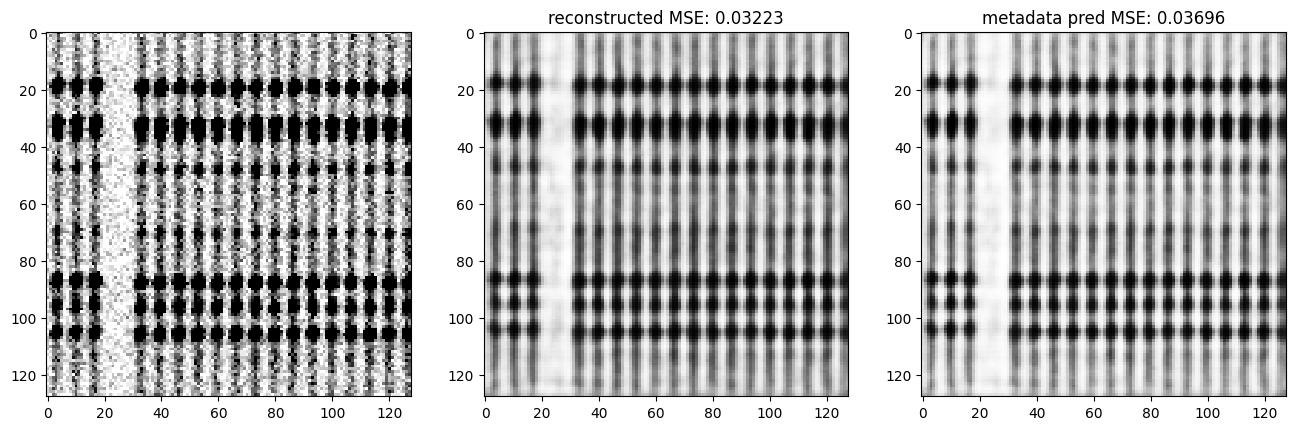

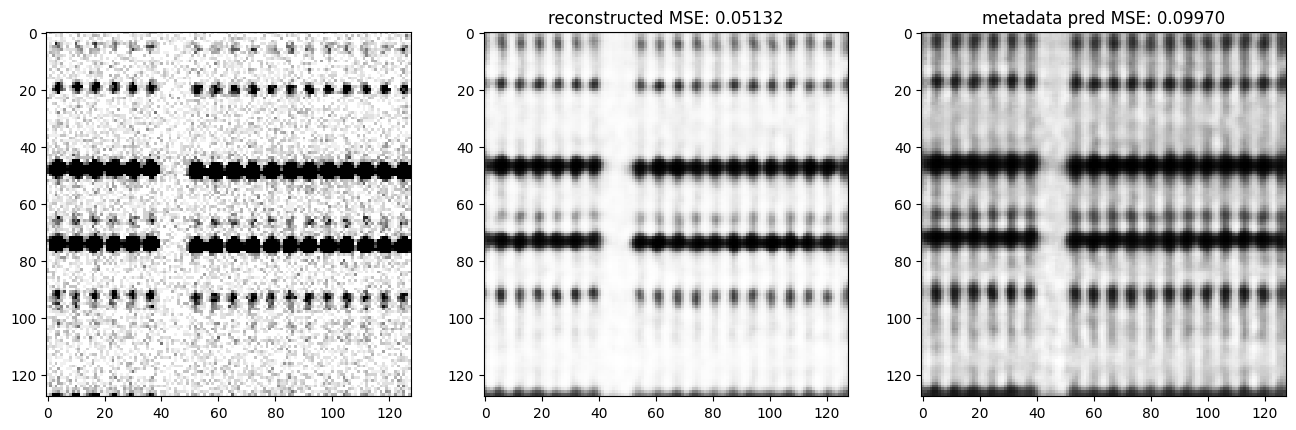

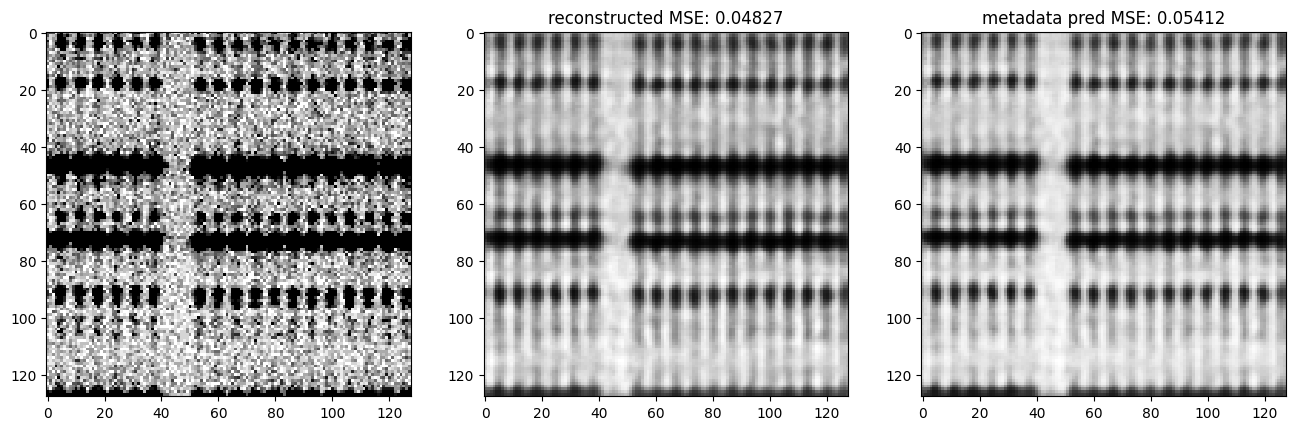

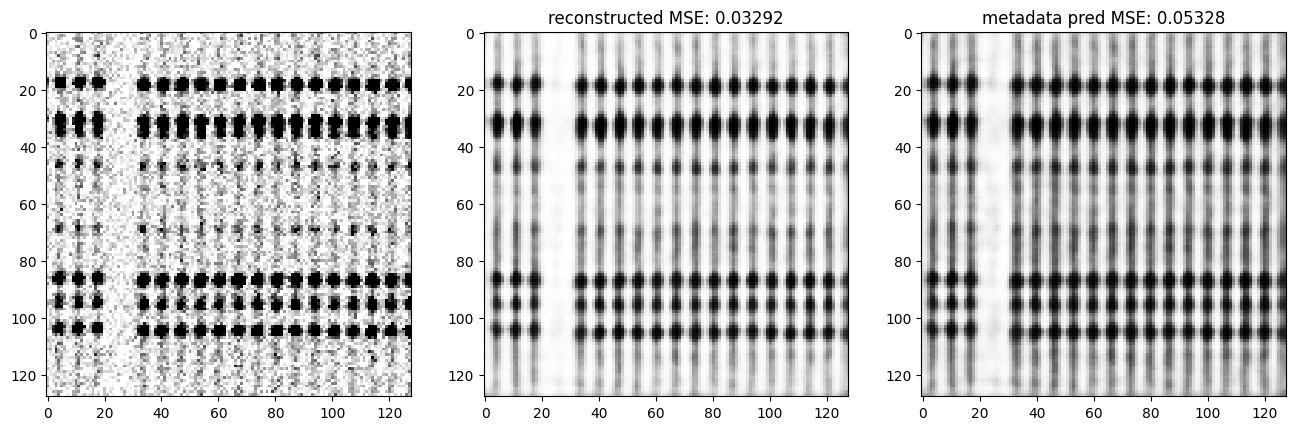

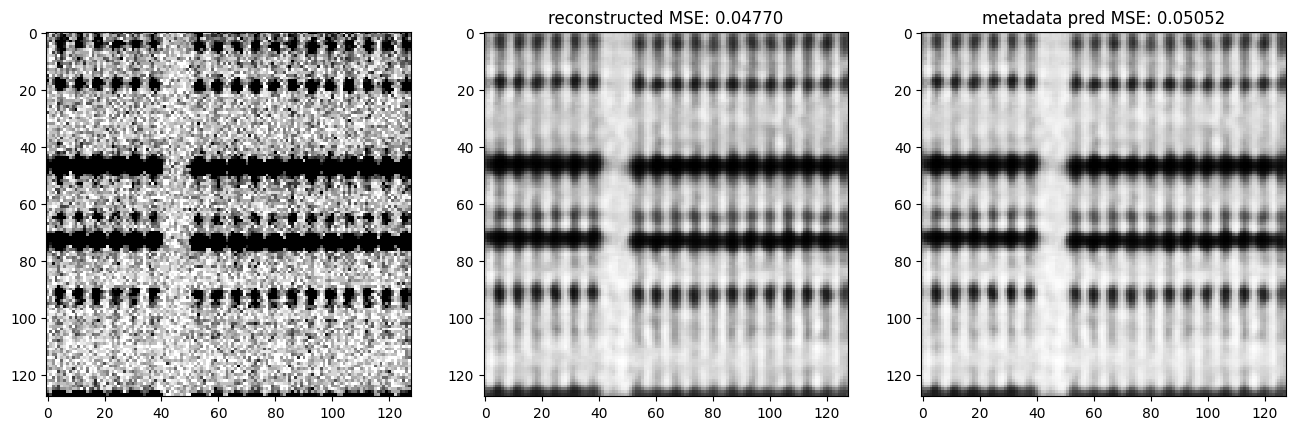

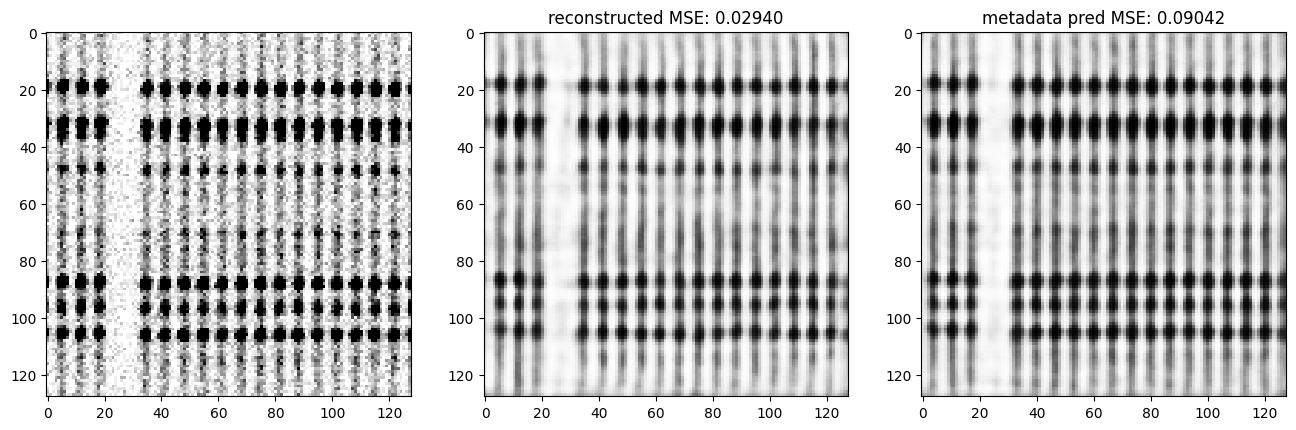

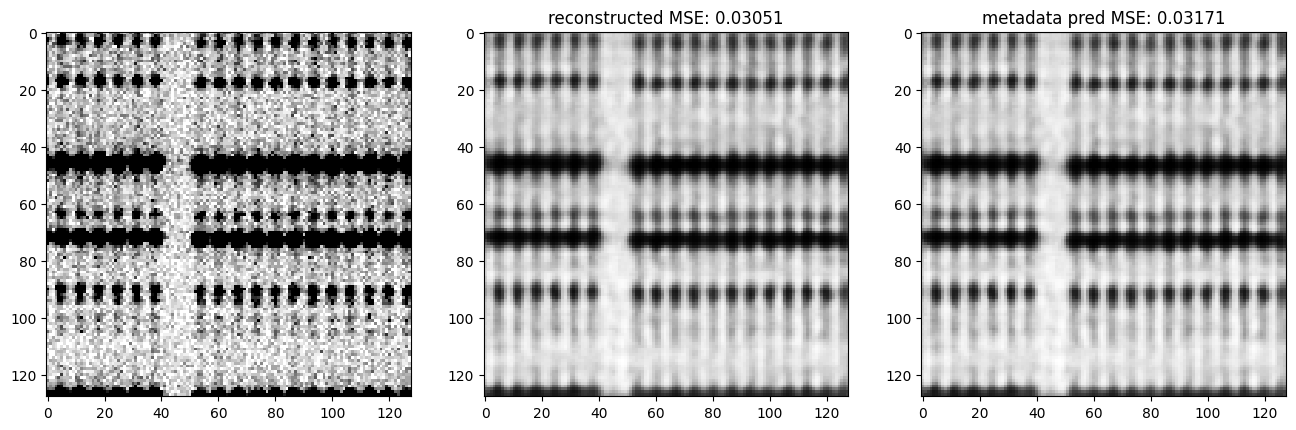

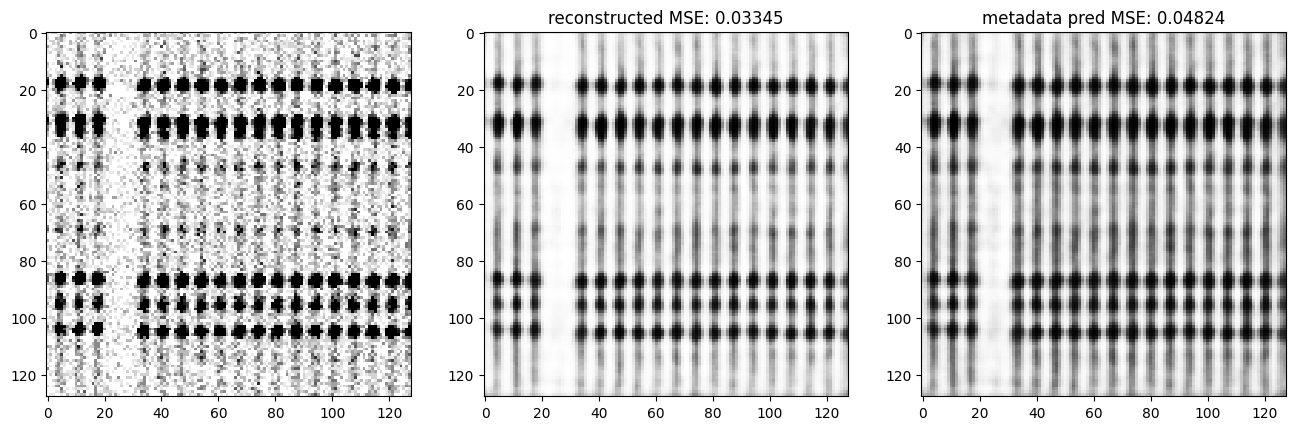

In [93]:
pred = mlp.predict(M_va)
reco_img = jax.vmap(model)(X_va)
pred_img = jax.vmap(model.decoder)(pred)

print(f'reco mse (va): {mse_loss(reco_img, X_va)}')
print(f'pred mse (va): {mse_loss(pred_img, X_va)}')

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].imshow(X_va[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].imshow(reco_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[1].set_title(f"reconstructed MSE: {mse_loss(reco_img[i], X_va[i]):.5f}")
    axs[2].imshow(pred_img[i].squeeze(), cmap='binary', interpolation='nearest')
    axs[2].set_title(f"metadata pred MSE: {mse_loss(pred_img[i], X_va[i]):.5f}")
    plt.show()